# Comparing CollaGAN-3 with Pix2Pix and StarGAN

This notebook compares the images generated with CollaGAN-3 (receiving 3 source images) with Pix2Pix and StarGAN
(both receiving a single source image).

The CollaGAN model used no dropout during training. For the metrics, the Pix2Pix and StarGAN translated images from all the domains 
other than the target, and we averaged the values.

In [1]:
import logging_utils

from ModelProxy import Pix2PixModelProxy, StarGANModelProxy, CollaGANModelProxy

logging_utils.configure()

model_loaders = {
    'pix2pix': lambda: Pix2PixModelProxy('models/pix2pix'),
    'stargan': lambda: StarGANModelProxy('models/stargan'),
    'collagan': lambda: CollaGANModelProxy('models/collagan'),
}

2025-05-30 15:42:58.899329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 15:42:58.943810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 15:42:58.943864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 15:42:58.963623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 15:43:10.147933: W tensorflow/compiler/tf

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)

## Generates Images for a Qualitative Analysis


In [3]:
import tensorflow as tf


def generate_batch_with_each_model(number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    batch_transpose = None
    if mode == "specific_samples":
        batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
        batch = tf.stack(batch, axis=0)
        batch_transpose = batch
    elif mode == "random_batch":
        # loads a batch of images
        batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_4batches*4).take(1)))
        batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
    
    genned_images = []    
    target_indices = tf.repeat(tf.range(0, 4), [number_of_4batches] * 4)
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
    source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    for model_name, model_loader in model_loaders.items():
        # loads the model into memory
        generator = model_loader()    
        # generates the images
        fake_images = []
        for sample_idx, target_domain in enumerate(target_indices):
            fake_images_of_example = []
            for source_domain in range(4):
                if source_domain == target_domain:
                    single_fake_image = tf.ones_like(target_images[0])[tf.newaxis, ...] * -1.
                else:
                    single_fake_image = generator.generate(source_domain, target_domain, source_images[sample_idx][:, tf.newaxis, ...])
                fake_images_of_example += [single_fake_image]
            fake_images_of_example = tf.concat(fake_images_of_example, axis=0)
            fake_images += [fake_images_of_example]
        fake_images = tf.stack(fake_images, axis=0)

        genned_images += [fake_images]
        # frees the memory used by the model
        del generator

    # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
    target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
    source_images += target_in_source_mask * -1
    return source_images, target_images, genned_images, target_indices, list(model_loaders.keys())


from dataset_utils import stsn
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    stsn["misc"]+782,   #   
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    stsn["misc"]+207,
    stsn["misc"]+1701,  # misc tiny butt
    stsn["rm2k"]+20,  #
    stsn["rmxp"]+5,     # rmxp cook
    stsn["rmvx"]+27,    # rmvx santa
    
    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
imgs_params = generate_batch_with_each_model(2, example_numbers)


2025-05-30 15:43:35 WARNING  5 out of the last 5 calls to <function DatasetLoader.load_paired_images at 0x7faaf2addca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2025-05-30 15:43:35 WARNING  6 out of the last 6 calls to <function DatasetLoader.load_paired_images at 0x7faaf2addca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2025-05-30 15:43:36 INFO     Start >> Loading Pix2Pix model left-to-back
2025-05-30 15:43:41 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 15:43:41 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-05-30 15:43:41 INFO     End   >> Lo

/mnt/d/Projetos 2/dissertation-notebooks/image_utils.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


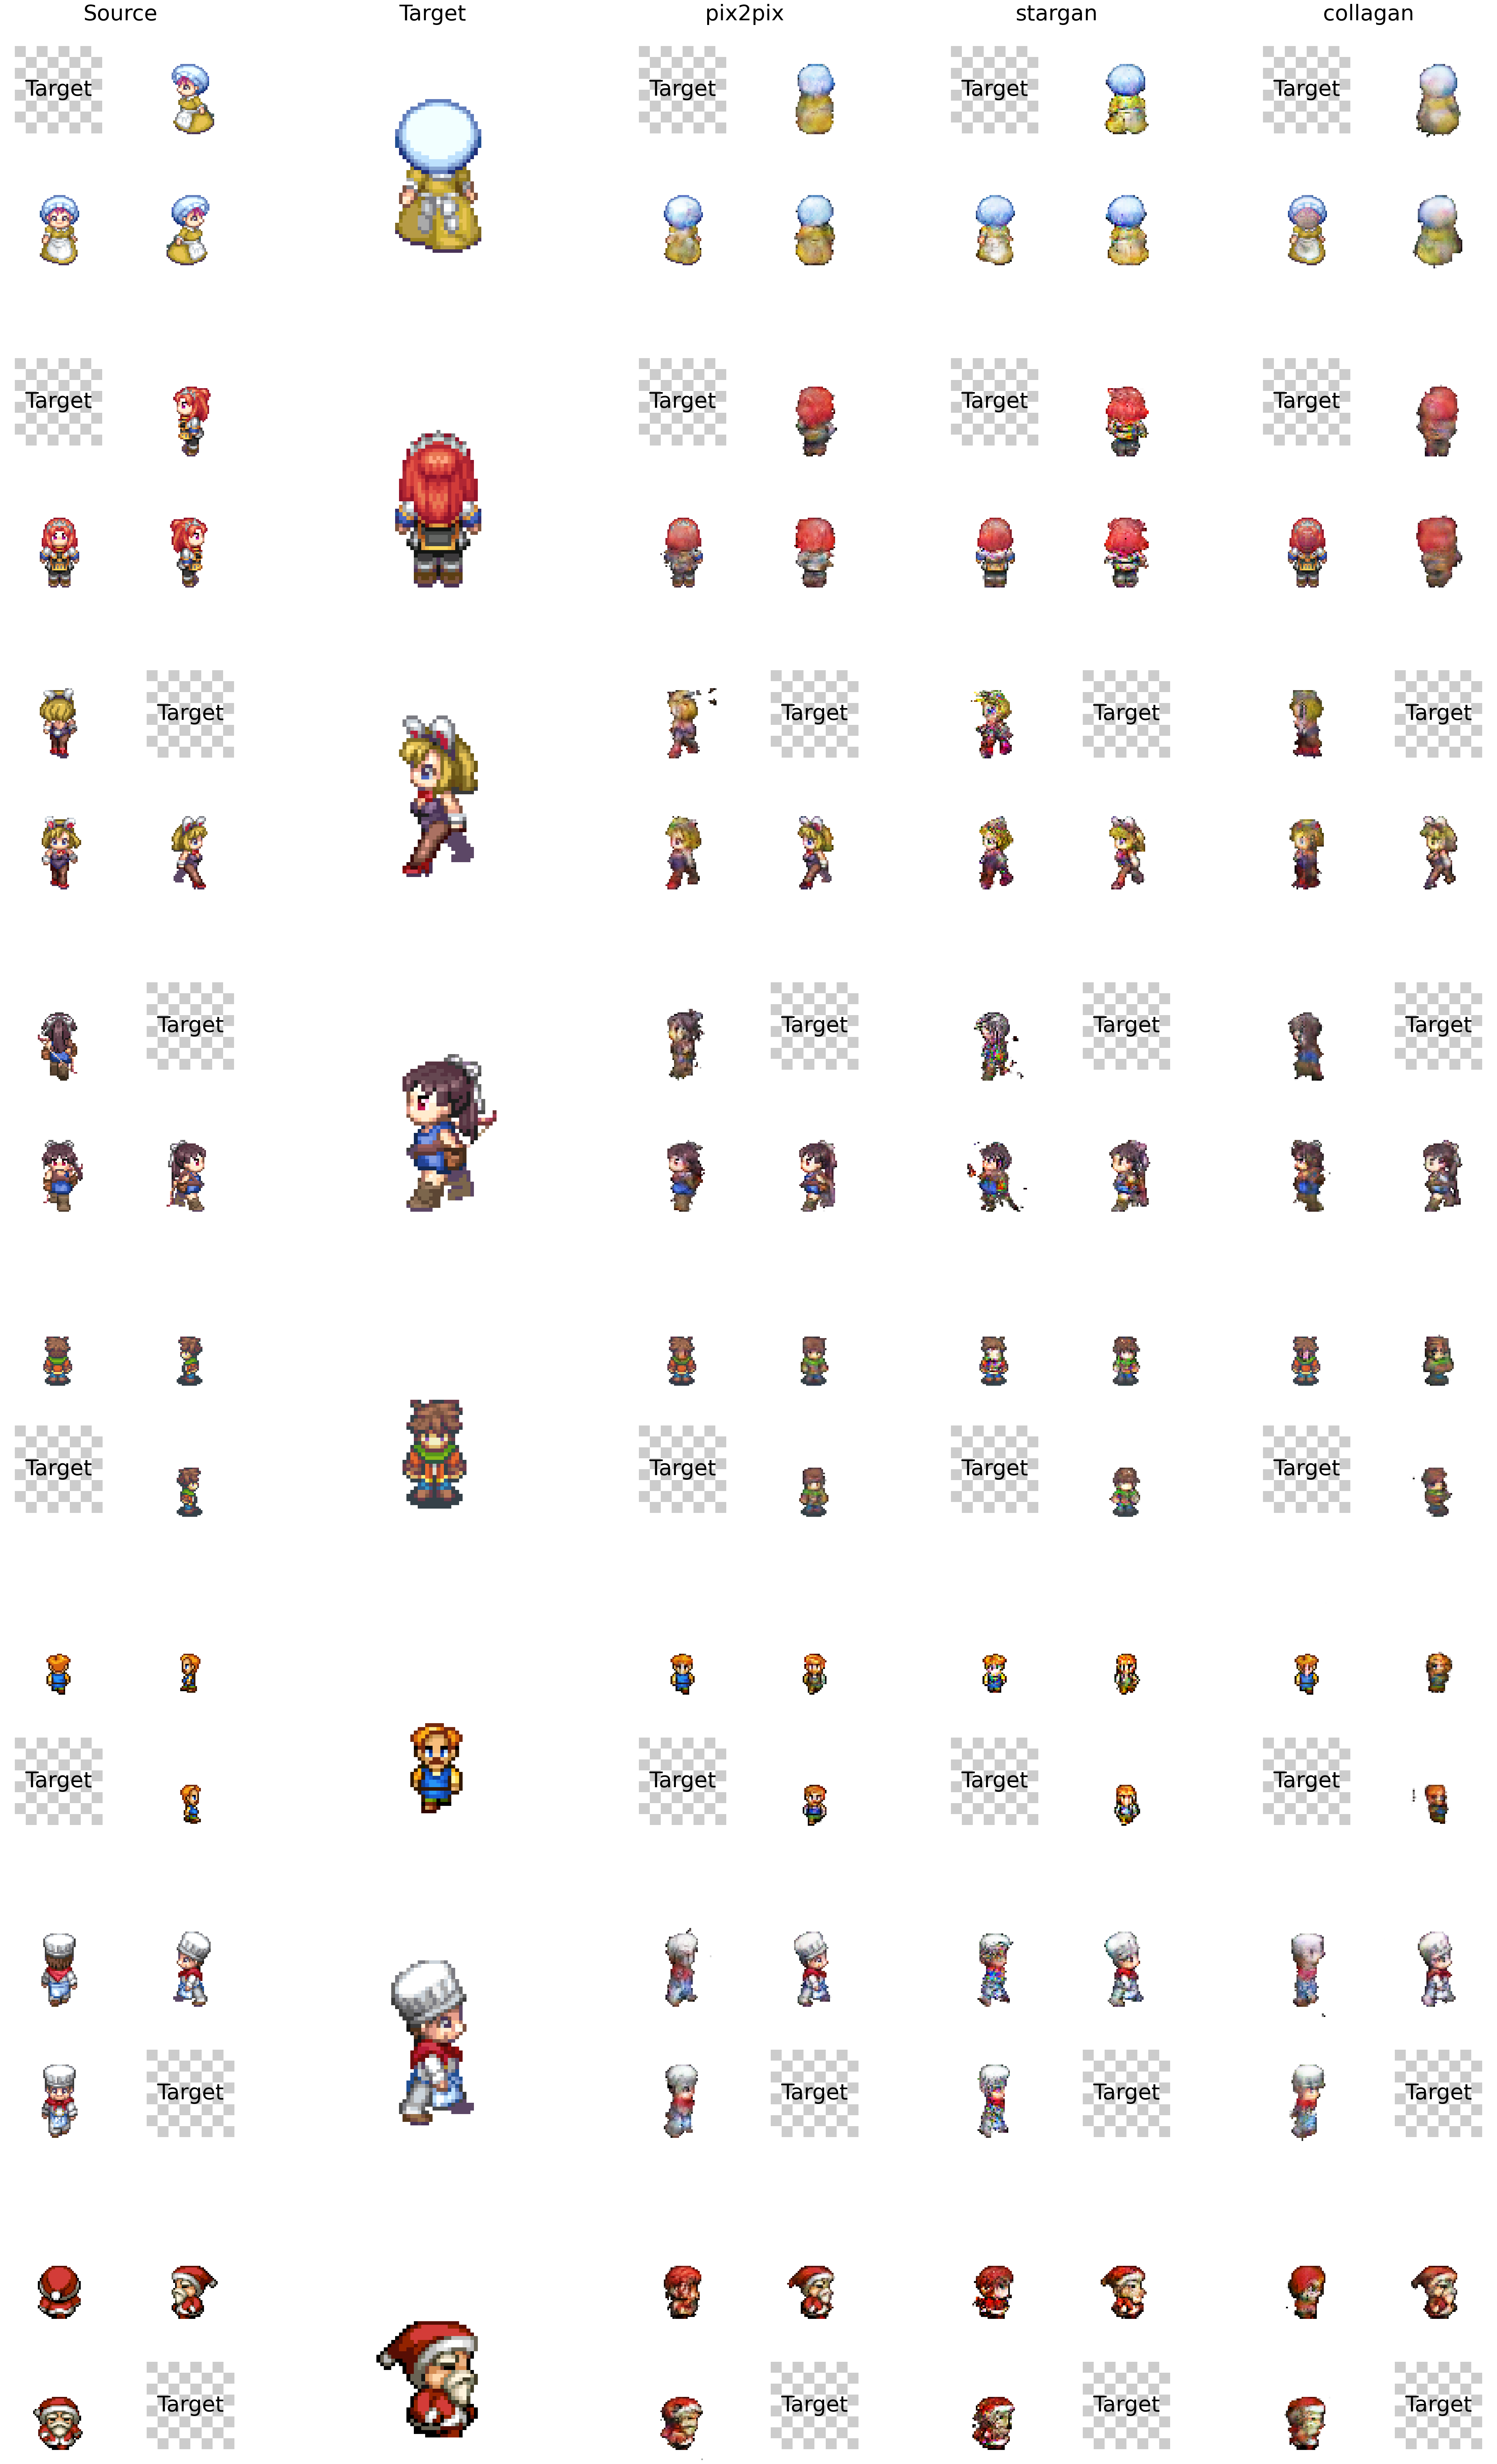

In [4]:
from matplotlib import pyplot as plt
from image_utils import show_comparison

f = show_comparison(*imgs_params)
f.patch.set_alpha(0.0)
plt.savefig("output/single_input_comparison.png", format="png", transparent=True)
